# <span style='color:SteelBlue'>P5 - Segmentez des clients d'un site e-commerce (part 1)</span>

<img src="https://asset.brandfetch.io/idvSn4Org5/idCJV4h5Ot.png" width="400" height="400">

<div class="alert alert-block alert-info"><b>Tip: </b> Use blue boxes for Tips and notes. If it's a note, you don't have to include the word "Note". </div> 

<div class="alert alert-block alert-warning"><b>Example: </b> Use yellow boxes for examples that are not inside code cells, or use for mathematical formulas if needed.</div>

<div class="alert alert-block alert-success"><b>Up to you: </b>Use green boxes sparingly, and only for some specific purpose that the other boxes can't cover. For example, if you have a lot of related content to link to, maybe you decide to use green boxes for related links from each section of a notebook. </div>

<div class="alert alert-block alert-danger"><b>Just don't: </b>In general, just avoid the red boxes. </div>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

# <span style='background:red; color:white'>A METTRE A JOUR</span>

**Etape 1 : Description des données**
- _1/ Les clients_
- _2/ Les géolocalisations_
- _3/ Les articles_
- _4/ Les paiements_
- _5/ Les avis_
- _6/ Les données de base_
- _7/ Les produits_
- _8/ Les vendeurs_
- _9/ Les traductions_

**Etape 2 : Nettoyage des données**
- _1/ 

**Etape 3 : Analyse exploratoire**
- _1/ Analyses univariées_
- _2/ Analyses bivariées_
- _3/ Analyses multivariées_

**Etape 4 : Exportation du dataset nettoyé**

Conclusion

# <span style='background:blue'>Introduction</span>

Olist souhaite que nous fournissons à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Nous devons fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.
___

**Mission**

**Réaliser la segmentation des clients en utilisant des méthodes non-superviséees**. Notre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles. Pour cela nous devons :
1. Réaliser une courte analyse exploratoire.
2. Tester différents modèles de segmentation afin de répondre au mieux à la problématique.
3. Créer une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Ce notebook présente la 1ère partie. Nous allons donc réaliser **une courte analyse exploratoire** après avoir nettoyé les données si nécessaire. Le but sera de déterminer les variables pertinentes ou d'en créer de nouvelles (feature engineering).
___

**Source des datasets**<br>
Olist nous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Source : [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce)<br>

9 fichiers CSV :
- olist_customers_dataset.csv
- olist_geolocation_dataset.csv
- olist_order_items_dataset.csv
- olist_order_payments_dataset.csv
- olist_order_reviews_dataset.csv
- olist_orders_dataset.csv
- olist_products_dataset.csv
- olist_sellers_dataset.csv
- product_category_name_translation.csv

Relations entre les fichiers CSV :
<br><br>
<img src="https://i.imgur.com/HRhd2Y0.png" width="800" height="500">

<br>
Pour info, voici la segmentation RFM réalisée par notre prédécesseur il y a quelques années :
<br><br>
<img src="https://user.oc-static.com/upload/2023/03/21/16793895608947_Screenshot%202023-03-21%20at%2010.05.50.png" width="600" height="300">
___

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [150]:
# Librairies
import os.path
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
import numpy as np
import time
from IPython.display import display
import scipy
from scipy.stats import shapiro
from datetime import datetime

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.3
Scipy         : 1.11.4
Seaborn       : 0.13.0

Code lancé le : 2023-12-06T17:08:20.868166


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [151]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# Seuil de significativité des tests statistiques
seuil_significativite = 0.05

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [152]:
#                          AFFICHE APERCU DF
# ****************************************************************************

def affiche_aperçu_df(df: pd.DataFrame, str_df, str_explication, nb_head):
    """
    Procédure qui affiche un aperçu d'un dataframe
    
    :param: df : data frame à analyser (df)
    :param: str_df : nom du data frame à analyser (str)
    :param: str_explication : explication de la modification (str)
    :param: nb_head : nombre de ligne pour la méthode 'head' (int)
    """
    
    # Affichage du nom du dataframe et de l'explication
    print("Voici l'aspect de '{0}' après {1}".format( str_df, str_explication)) 
    
    # Affichage des x premières lignes du dataframe
    display(df.head(nb_head))
    
    # Affichage dimension du dataframe (ligne et col)
    dim = df.shape
    print('{0} ligne(s) x {1} colonne(s)\n'.format(str(dim[0]), str(dim[1])))

In [153]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color, binwidth=None, shapiro_wilk=False, unit=None):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme et une boîte à moustaches.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    :param binwidth: largeur des barres de l'histogramme (int or float) (optionnel)
    :param shapiro_wilk: Effectuer le test de Shapiro-Wilk (booléen) (optionnel)
    :param unit: Unités pour l'axe X (str) (optionnel)
    """
    
    # Création de sous-plots pour l'histogramme et la boîte à moustaches
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # SI le test de Shapiro-Wilk est effectué
    if shapiro_wilk:
        
        # Effectuez test de S-W et écrire le résultat dans le titre du graphique
        sw_statistic, p_value = shapiro(df[col])
        sw_texte = "Distribution '{0}' Test S-W :{1:.2f} / p-value = {2:.2f}".format(col,sw_statistic, p_value)
        axes[0].set_title(sw_texte, fontdict=font_title, fontsize=14)
    else:
        # SI pas de test de Shapiro-Wilk, affichage titre par défaut
        axes[0].set_title("Distribution '{0}'".format(col), fontdict=font_title)
    
    # Graphique de l'histogramme
    if binwidth is not None:
        sns.histplot(df[col], kde=False, color=color, binwidth=binwidth, ax=axes[0])
    else:
        sns.histplot(df[col], kde=False, color=color, ax=axes[0])
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[0].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[0].set_xlabel("Valeur", fontdict=font_axe)
    
    # Graphique de la boîte à moustaches
    sns.boxplot(x=df[col], color=color, ax=axes[1])
    axes[1].set_title("Boxplot '{0}'".format(col), fontdict=font_title)
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[1].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[1].set_xlabel("Valeur", fontdict=font_axe)
    
    # Ajustement de l'espacement entre les sous-plots
    plt.tight_layout()
    
    # Affichage des graphiques
    plt.show()

In [156]:
# #                            CONVERTISSEUR STR TO DATETIME
# # ****************************************************************************

def convertisseur_str_to_datetime(datetime_string):
    """
    Convertit une chaîne de caractères représentant une date et une heure en un objet datetime.
    
    Args:
        datetime_string (str): La chaîne de caractères à convertir, qui doit être au format "AAAA-MM-JJ HH:MM:SS".
    
    Returns:
        datetime.datetime: L'objet datetime correspondant à la chaîne de caractères donnée.
    """
    # Convertion de la chaîne de caractères en un objet datetime
    datetime_object = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M:%S")
    
    # Outputs
    return datetime_object

In [157]:
# #                            PLOT DISTRIBUTION DATETIME
# # ****************************************************************************

def plot_distribution_datetime(df, datetime_col):
    """
    Procédure qui affiche les distributions des composants d'une donnéee datetime dans un ensemble de sous-graphiques.
    
    Paramètres
    ----------
    df : pandas.DataFrame
        Le DataFrame contenant les données à tracer. Doit contenir les colonnes 'year', 'month', 'day', 'hour', 'minute' et 'second'.
    """
    # crée une copie du DataFrame
    df_copie = df.copy()
    
    # Extraire les composants de la date
    df_copie['year'] = df[datetime_col].dt.year
    df_copie['month'] = df[datetime_col].dt.month
    df_copie['day'] = df[datetime_col].dt.day
    df_copie['hour'] = df[datetime_col].dt.hour
    df_copie['minute'] = df[datetime_col].dt.minute
    df_copie['second'] = df[datetime_col].dt.second
    
    # Création de subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Ajouter un titre
    fig.suptitle('Distribution des composants de la date et de l\'heure', fontdict=font_title)
    
    # Convertir les étiquettes de l'axe x en entiers
    formatter = FuncFormatter(lambda x, pos: '%.0f' % x)
    axes[0, 0].xaxis.set_major_formatter(formatter)
    
    # Distribution des années
    sns.histplot(df_copie['year'], kde=False, ax=axes[0, 0], color='blue')
    axes[0, 0].set_xlabel('Année')
    
    # Réduire le nombre d'étiquettes sur l'axe x
    start, end = axes[0, 0].get_xlim()
    axes[0, 0].xaxis.set_ticks(np.arange(start, end, step=1))
    
    # Distribution des mois
    sns.histplot(df_copie['month'], kde=False, ax=axes[0, 1], color='green')
    axes[0, 1].set_xlabel('Mois')
    
    # Distribution des jours
    sns.histplot(df_copie['day'], kde=False, ax=axes[0, 2], color='red')
    axes[0, 2].set_xlabel('Jour')
    
    # Distribution des heures
    sns.histplot(df_copie['hour'], kde=False, ax=axes[1, 0], color='purple')
    axes[1, 0].set_xlabel('Heure')
    
    # Distribution des minutes
    sns.histplot(df_copie['minute'], kde=False, ax=axes[1, 1], color='orange')
    axes[1, 1].set_xlabel('Minute')
    
    # Distribution des secondes
    sns.histplot(df_copie['second'], kde=False, ax=axes[1, 2], color='pink')
    axes[1, 2].set_xlabel('Seconde')
    
    plt.tight_layout()
    plt.show()

In [158]:
# #                            AFFICHEUR DIMENSION ET UNIQUE
# # ****************************************************************************

def afficheur_dimension_et_unique(df, df_name, type_donnee, col_name):
    """
    Procédure qui affiche le nombre de lignes et de commandes différentes dans un DataFrame.
    
    Paramètres
    ----------
    df : pandas.DataFrame
        Le DataFrame pour lequel compter le nombre de lignes et de commandes différentes.
    df_name : str
        Le nom du DataFrame.
    col_name : str
        Le nom de la colonne pour laquelle compter le nombre de valeurs uniques.
    """
    # Afficher le nombre de lignes 
    print("'{0}' contient {1} lignes et {2} colonnes".format(df_name, df.shape[0], df.shape[1]))
    
    # Afficher le nombre de 'type_donnee' différentes
    print("'{0}' contient {1} {2} différent(e)s".format(df_name, df[col_name].nunique(), type_donnee))

# <span style='background:grey'>Importation des données</span>

Importation des fichiers CSV avec Pandas

In [159]:
# Définir le chemin
chemin = "./data/source/"

# Obtenir une liste de tous les fichiers dans le répertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et le print de la liste des fichiers importés
data_brut = {}
print('===> Liste des fichiers importés: <====\n')

# Boucle sur chaque fichier
for fichier in fichiers:
    
    # Traiter uniquement les fichiers .csv
    if fichier.endswith('.csv'):
        print(fichier)
        
        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(chemin + fichier, sep=",", encoding='utf-8')

===> Liste des fichiers importés: <====

olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_orders_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


# <span style='background:blue'>Etape 1 : Description des données</span>

## <span style='background:yellow; color:black'>1/ Les clients</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [160]:
# isoler le contenu du fichier
fichier = data_brut['olist_customers_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


Informations sur les clients :
- **customer_id** : identifiant des commandes
- **customer_unique_id** : identifiant des clients
- **customer_zip_code_prefix** : code postal du client (premiers chiffres uniquement)
- **customer_city** : ville du client
- **customer_state** : état du client

### <span style='background:green'>b/ Structure</span>

In [161]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Le fichier contient 99_441 lignes et 5 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [162]:
fichier.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>d/ Doublons</span>

In [163]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [164]:
fichier.describe().round(2)

,customer_zip_code_prefix
count,99441.00
mean,35137.47
std,29797.94
min,1003.00
25%,11347.00
50%,24416.00
75%,58900.00
max,99990.00


Résumé des features **qualitatives** : 

In [165]:
fichier.describe(exclude=[np.number])

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


<div class="alert alert-block alert-info"><b>Fichier client </b> : 'olist_customers_dataset.csv' 
 
Ce fichier contient plus de 99_000 commandes avec plus de 96_000 clients différents. Il y a moins de clients que de commandes. Certains clients ont donc passé plusieurs commandes (env. 3%).

Ce fichier est lié au fichier des **géolocalisations** grâce à la clef "**customer_zip_code_prefix**".<br>
Ce fichier est lié au fichier des **données de base** grâce à la clef "**customer_id**". 
</div>

## <span style='background:yellow; color:black'>2/ les géolocalisations</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [166]:
# isoler le contenu du fichier
fichier = data_brut['olist_geolocation_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.54562,-46.63929,sao paulo,SP
1,1046,-23.54608,-46.64482,sao paulo,SP
2,1046,-23.54613,-46.64295,sao paulo,SP


Informations sur la géolocalisation des clients :
- **geolocation_zip_code_prefix** : code postal du client (premiers chiffres uniquement)
- **geolocation_lat** : latitude du client
- **geolocation_lng** : longitude du client
- **geolocation_city** : ville d'habitation du client
- **geolocation_state** : état d'habitation du client

### <span style='background:green'>b/ Structure</span>

In [167]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


Il y a 1_000_163 lignes et 5 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [168]:
fichier.isna().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>d/ Doublons</span>

In [169]:
fichier.duplicated().sum()

261831

Il y a 261_831 doublons de ligne identiques. 

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [170]:
fichier.describe().round(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1000163.00,1000163.00,1000163.00
mean,36574.17,-21.18,-46.39
std,30549.34,5.72,4.27
min,1001.00,-36.61,-101.47
25%,11075.00,-23.60,-48.57
50%,26530.00,-22.92,-46.64
75%,63504.00,-19.98,-43.77
max,99990.00,45.07,121.11


Résumé des features **qualitatives** : 

In [171]:
fichier.describe(exclude=[np.number])

,geolocation_city,geolocation_state
count,1000163,1000163
unique,8011,27
top,sao paulo,SP
freq,135800,404268


<div class="alert alert-block alert-info"><b>Fichier géolocalisation </b> : 'olist_geolocation_dataset.csv'

Ce fichier présente plus d'un million de lignes sans aucune valeur manquante concernant la localisation des clients. Les commandes ont été réalisées dans plus de 8_000 villes différentes dans 27 états différents. 

Ce fichier est lié au fichier des **clients** grâce à la clef "**geolocation_zip_code_prefix**".<br>
Ce fichier est lié au fichier des **vendeurs** grâce à la clef "**geolocation_zip_code_prefix**". 
</div>

## <span style='background:yellow; color:black'>3/ Les articles</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [172]:
# isoler le contenu du fichier
fichier = data_brut['olist_order_items_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


Informations sur les articles :
- **order_id** : identifiant des commandes
- **order_item_id** : nombre d'articles commandés
- **product_id** : identifiant des produits
- **seller_id** : identifiant des vendeurs
- **shipping_limit_date** : date limite d'envoi
- **price** : prix
- **freight_value** : valeur du fret

### <span style='background:green'>b/ Structure</span>

In [173]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


Ce fichier contient 112_650 lignes et 7 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [174]:
fichier.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>d/ Doublons</span>

In [175]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [176]:
fichier.describe().round(2)

,order_item_id,price,freight_value
count,112650.00,112650.00,112650.00
mean,1.20,120.65,19.99
std,0.71,183.63,15.81
min,1.00,0.85,0.00
25%,1.00,39.90,13.08
50%,1.00,74.99,16.26
75%,1.00,134.90,21.15
max,21.00,6735.00,409.68


Résumé des features **qualitatives** : 

In [177]:
fichier.describe(exclude=[np.number])

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


<div class="alert alert-block alert-info"><b>Fichier article </b> : 'olist_order_items_dataset.csv'

Ce fichier contient plus de 112_000 commandes avec plus de 32_000 produits différents pour plus de 3_000 vendeurs différents.<br>
La commande moyenne contient 1,2 article pour 120 R$ (Réal brésilien) de prix et 20 R$ de frais de port.

Ce fichier est lié au fichier des **commandes** grâce à la clef "**order_id**".<br>
Ce fichier est lié au fichier des **produits** grâce à la clef "**product_id**".<br>
Ce fichier est lié au fichier des **vendeurs** grâce à la clef "**seller_id**".
</div>

## <span style='background:yellow; color:black'>4/ Les paiements</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [178]:
# isoler le contenu du fichier
fichier = data_brut['olist_order_payments_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


Informations sur les paiements :
- **order_id** : identifiant des commandes
- **payment_sequential** : nombre de séquence de paiements pour différents modes de paiement
- **payment_type** : type de paiement
- **payment_installments** : nombre de versement de paiement
- **payment_value** : montant du paiement

### <span style='background:green'>b/ Structure</span>

In [179]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Ce fichier contient 103_886 lignes et 5 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [180]:
fichier.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>d/ Doublons</span>

In [181]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [182]:
fichier.describe().round(2)

,payment_sequential,payment_installments,payment_value
count,103886.00,103886.00,103886.00
mean,1.09,2.85,154.10
std,0.71,2.69,217.49
min,1.00,0.00,0.00
25%,1.00,1.00,56.79
50%,1.00,1.00,100.00
75%,1.00,4.00,171.84
max,29.00,24.00,13664.08


Résumé des features **qualitatives** : 

In [183]:
fichier.describe(exclude=[np.number])

,order_id,payment_type
count,103886,103886
unique,99440,5
top,fa65dad1b0e818e3ccc5cb0e39231352,credit_card
freq,29,76795


<div class="alert alert-block alert-info"><b>Fichier paiement </b> : 'olist_order_payments_dataset.csv'

Ce fichier contient plus de 103_000 paiements pour plus de 99_000 commandes différentes.<br>
Le paiement moyen comporte 1,09 séquence avec 2,85 versements pour un montant de 154 R$.<br>
Il y a 5 types de paiements différents.

Ce fichier est lié au fichier des **données de base** grâce à la clef "**order_id**".
</div>

## <span style='background:yellow; color:black'>5/ Les avis</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [184]:
# isoler le contenu du fichier
fichier = data_brut['olist_order_reviews_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


Informations sur les avis :
- **review_id** : identifiant des avis
- **order_id** : identifiant des commandes
- **review_score** : score/note de l'avis
- **review_comment_title** : titre de l'avis
- **review_comment_message** : message de l'avis
- **review_creation_date** : date de création de l'avis
- **review_answer_timestamp** : date de réponse de l'avis

### <span style='background:green'>b/ Structure</span>

In [185]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Ce fichier contient 99_224 lignes et 7 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [186]:
fichier.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Il y a 87_656 valeurs manquantes dans la colonne "**review_comment_title**".<br>
Il y a 58_247 valeurs manquantes dans la colonne "**review_comment_message**".

### <span style='background:green'>d/ Doublons</span>

In [187]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [188]:
fichier.describe().round(2)

,review_score
count,99224.00
mean,4.09
std,1.35
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


Résumé des features **qualitatives** : 

In [189]:
fichier.describe(exclude=[np.number])

,review_id,order_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,11568,40977,99224,99224
unique,98410,98673,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,423,230,463,4


<div class="alert alert-block alert-info"><b>Fichier avis </b> : 'olist_order_reviews_dataset.csv'

Ce fichier contient plus de 99_000 avis pour plus de 98_000 commandes différentes.<br>
La note moyenne était de 4,09 /5.<br>
Seulement 41_000 avis possèdent un message et 11_500 avis possèdent un titre.

Ce fichier est lié au fichier des **données de base** grâce à la clef "**order_id**".
</div>

## <span style='background:yellow; color:black'>6/ Les données de base</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [190]:
# isoler le contenu du fichier
fichier = data_brut['olist_orders_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Informations sur les données de base :
- **order_id** : identifiant des commandes
- **customer_id** : identifiant des clients
- **order_status** : statut de la commande
- **order_purchase_timestamp** : date d'achat de la commande
- **order_approved_at** : date d'approbation du paiement de la commande
- **order_delivered_carrier_date** : date de prise en charge de la commande par le transporteur
- **order_delivered_customer_date** : date de livraison de la commande au client
- **order_estimated_delivery_date** : date estimée de livraison de la commande

### <span style='background:green'>b/ Structure</span>

In [191]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


Ce fichier contient 99_441 lignes et 8 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [192]:
fichier.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Il y a 160 valeurs manquantes dans la colonne "**order_approved_at**".<br>
Il y a 1_783 valeurs manquantes dans la colonne "**order_delivered_carrier_date**".<br>
Il y a 2_965 valeurs manquantes dans la colonne "**order_delivered_customer_date**".

### <span style='background:green'>d/ Doublons</span>

In [193]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **qualitatives** : 

In [194]:
fichier.describe(exclude=[np.number])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


<div class="alert alert-block alert-info"><b>Fichier données de base </b> : 'olist_orders_dataset.csv'

Ce fichier contient des données de base pour plus de 99_000 commandes de 99_000 clients.<br>
Seulement 96_000 commandes ont été livrées.<br>
Il manque 160 dates d'approbation de paiement, 1_783 dates de prise en charge par le transporteur et 2_965 dates de livraison au client.

Ce fichier est lié au fichier des **paiements** grâce à la clef "**order_id**".<br>
Ce fichier est lié au fichier des **avis** grâce à la clef "**order_id**".<br>
Ce fichier est lié au fichier des **articles** grâce à la clef "**order_id**".<br>
Ce fichier est lié au fichier des **clients** grâce à la clef "**customer_id**".
</div>

## <span style='background:yellow; color:black'>7/ Les produits</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [195]:
# isoler le contenu du fichier
fichier = data_brut['olist_products_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


Informations sur les produits :
- **product_id** : identifiant des produits
- **product_category_name** : catégorie des produits
- **product_name_lenght** : longueur du nom du produit
- **product_description_lenght** : longueur de la description du produit
- **product_photos_qty** : nombre de photos du produit
- **product_weight_g** : poids du produit (en g)
- **product_length_cm** : longueur du produit (en cm)
- **product_height_cm** : hauteur du produit (en cm)
- **product_width_cm** : largeur du produit (en cm)

### <span style='background:green'>b/ Structure</span>

In [196]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Ce fichier contient 32_951 lignes et 9 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [197]:
fichier.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Il y a 610 valeurs manquantes dans la colonne "**product_category_name**", "**product_name_lenght**", "**product_description_lenght**" et "**product_photos_qty**".<br>

Il y a 2 valeurs manquantes dans la colonne "**product_weight_g**", "**product_length_cm**", "**product_height_cm**" et "**product_width_cm**".

### <span style='background:green'>d/ Doublons</span>

In [198]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [199]:
fichier.describe().round(2)

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.00,32341.00,32341.00,32949.00,32949.00,32949.00,32949.00
mean,48.48,771.50,2.19,2276.47,30.82,16.94,23.20
std,10.25,635.12,1.74,4282.04,16.91,13.64,12.08
min,5.00,4.00,1.00,0.00,7.00,2.00,6.00
25%,42.00,339.00,1.00,300.00,18.00,8.00,15.00
50%,51.00,595.00,1.00,700.00,25.00,13.00,20.00
75%,57.00,972.00,3.00,1900.00,38.00,21.00,30.00
max,76.00,3992.00,20.00,40425.00,105.00,105.00,118.00


Résumé des features **qualitatives** : 

In [200]:
fichier.describe(exclude=[np.number])

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho
freq,1,3029


<div class="alert alert-block alert-info"><b>Fichier produits </b> : 'olist_products_dataset.csv'

Ce fichier contient plus de 32_000 produits dans 73 catégories différentes.<br>
Il y a 610 produits sans catégorie, nom, description ou photo.<br>
Il y a 2 produits sans dimension ni poids.<br>

Le produit moyen pèse 2,276 kg pour une dimension de 31 x 17 x23 cm. Il est décrit avec un titre de 48 caractères et une description de 771 caractères avec 2 photos.<br>


Ce fichier est lié au fichier des **articles** grâce à la clef "**product_id**".
</div>

## <span style='background:yellow; color:black'>8/ Les vendeurs</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [201]:
# isoler le contenu du fichier
fichier = data_brut['olist_sellers_dataset.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


Informations sur les vendeurs :
- **seller_id** : identifiant des vendeurs
- **seller_zip_code_prefix** : code postal du vendeur (5 premiers chiffres uniquement)
- **seller_city** : ville de domiciliation du vendeur
- **seller_state** : état domiciliation du vendeur

### <span style='background:green'>b/ Structure</span>

In [202]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


Ce fichier contient 3_095 lignes et 4 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [203]:
fichier.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>d/ Doublons</span>

In [204]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [205]:
fichier.describe().round(2)

,seller_zip_code_prefix
count,3095.00
mean,32291.06
std,32713.45
min,1001.00
25%,7093.50
50%,14940.00
75%,64552.50
max,99730.00


Résumé des features **qualitatives** : 

In [206]:
fichier.describe(exclude=[np.number])

,seller_id,seller_city,seller_state
count,3095,3095,3095
unique,3095,611,23
top,3442f8959a84dea7ee197c632cb2df15,sao paulo,SP
freq,1,694,1849


<div class="alert alert-block alert-info"><b>Fichier vendeur </b> : 'olist_sellers_dataset.csv'

Ce fichier contient plus de 3_000 vendeurs dans 611 villes de 23 états.<br>

Ce fichier est lié au fichier des **articles** grâce à la clef "**seller_id**".<br>
Ce fichier est lié au fichier des **géolocalisations** grâce à la clef "**seller_zip_code_prefix**".
</div>

## <span style='background:yellow; color:black'>9/ Les traductions</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [207]:
# isoler le contenu du fichier
fichier = data_brut['product_category_name_translation.csv']

# Afficher les 3 premières lignes du fichier
fichier.head(3)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


Informations sur les traductions :
- **product_category_name** : catégorie des produits en portugais
- **product_category_name_english** : catégorie des produits en anglais

### <span style='background:green'>b/ Structure</span>

In [208]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


Ce fichier contient 71 lignes et 2 colonnes.

### <span style='background:green'>c/ Valeurs manquantes</span>

In [209]:
fichier.isna().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>d/ Doublons</span>

In [210]:
fichier.duplicated().sum()

0

Il n'y a pas de doublons.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **qualitatives** :

In [211]:
fichier.describe(exclude=[np.number])

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


<div class="alert alert-block alert-info"><b>Fichier traduction </b> : 'product_category_name_translation.csv'

Ce fichier contient 71 traductions de catégories en portugais et en anglais.<br>
</div>

# <span style='background:blue'>Etape 2 : Nettoyage des données</span>

## <span style='background:yellow; color:black'>1/ RGPD</span>

Avant toute utilisation des données personnelles des clients, nous devons nous assurer que nous respectons l'équivalent du RGPD au brésil : LGPD (_Lei Geral de Proteção de Dados_).

**Cette étape n'est pas réalisée dans ce notebook puisque c'est un notebook non cleané qui n'est pas à destination du client.** Mais ce travail sera à réaliser lors du notebook à fournir au client.

## <span style='background:yellow; color:black'>2/ Sélection des fichiers et features pertinentes</span>

Consignes du client Olist :<br>
_"La segmentation proposée des différents types de clients doit pouvoir au minimum pouvoir différencier les bons et moins bons clients en termes de commandes et de satisfaction. Il faut se concentrer sur les 3% des clients qui ont réalisés plusieurs commandes mais la segmentation doit être fait sur l'ensemble des clients."_

Nous allons sélectionner les fichiers du dataset pertinents pour notre analyse, à savoir les fichiers concernant : 

- Les clients
- Les articles
- Les paiements
- Les avis
- Les données de base

In [212]:
# Importation des fichiers retenus 
df_clients = data_brut['olist_customers_dataset.csv']
df_articles = data_brut['olist_order_items_dataset.csv']
df_paiements = data_brut['olist_order_payments_dataset.csv']
df_avis = data_brut['olist_order_reviews_dataset.csv']
df_base = data_brut['olist_orders_dataset.csv']

## <span style='background:yellow; color:black'>3/ Nettoyage fichier "client"</span>

### <span style='background:black; color:white'>a/ Selection des features à conserver</span>

- **customer_id** : identifiant des commandes
- **customer_unique_id** : identifiant des clients

In [213]:
# Feature à conserver
feat_a_garder = ["customer_id", "customer_unique_id"]

# Sélection des features à conserver
df_clients_clean = df_clients[feat_a_garder]

### <span style='background:black; color:white'>b/ Imputation valeurs manquantes</span>

Pas de valeur manquante.

### <span style='background:black; color:white'>c/ Gestion des outliers</span>

Pas néccessaire ici car ce ne sont que des données qualitatives. 

### <span style='background:black; color:white'>d/ Aperçu dataframe nettoyé</span>

In [214]:
affiche_aperçu_df(df_clients_clean, "df_clients_clean", "nettoyage", 3)

Voici l'aspect de 'df_clients_clean' après nettoyage


,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e


99441 ligne(s) x 2 colonne(s)



## <span style='background:yellow; color:black'>4/ Nettoyage fichier "article"</span>

### <span style='background:black; color:white'>a/ Selection des features à conserver</span>

- **order_id** : identifiant des commandes
- **order_item_id** : nombre d'articles commandés
- **price** : prix
- **freight_value** : valeur du fret

In [215]:
# Feature à conserver
feat_a_garder = ["order_id", "order_item_id", "price", "freight_value"]

# Sélection des features à conserver
df_articles_clean = df_articles[feat_a_garder]

### <span style='background:black; color:white'>b/ Imputation valeurs manquantes</span>

Pas de valeur manquante.

### <span style='background:black; color:white'>c/ Gestion des outliers</span>

Pas neccésaire pour "order_id" car ce sont des données qualitatives.<br>

Vérifions les données quantitatives :

In [216]:
df_articles_clean.describe().round(2)

,order_item_id,price,freight_value
count,112650.00,112650.00,112650.00
mean,1.20,120.65,19.99
std,0.71,183.63,15.81
min,1.00,0.85,0.00
25%,1.00,39.90,13.08
50%,1.00,74.99,16.26
75%,1.00,134.90,21.15
max,21.00,6735.00,409.68


Les données quantitatives sont toutes positives et avec des ordres de grandeur probables. Il n'y a donc pas de valeurs aberrantes.

# <span style='background:red; color:white'>debut modif</span>

In [217]:
# # Feature analysée
# feature_analyzed = ["price", "freight_value"]

In [218]:
# # Distribution
# plot_distribution(df_articles_clean, feature_analyzed[0], colors_list[0], unit="Prix (R$)", shapiro_wilk=True)

In [219]:
# # Distribution
# plot_distribution(df_articles_clean, feature_analyzed[1], colors_list[1], unit="Prix (R$)", shapiro_wilk=True)

Nous transformons les données en logarithme pour mieux visualiser les outliers.

In [220]:
# # Copie du dataframe
# df_articles_log = df_articles_clean.copy()

# # Transformation logarithmique (log(1+x))
# df_articles_log[feature_analyzed] = np.log1p(df_articles_log[feature_analyzed])

In [221]:
# # Distribution
# plot_distribution(df_articles_log, feature_analyzed[0], colors_list[0], unit="Prix (R$)", shapiro_wilk=True)

In [222]:
# # Distribution
# plot_distribution(df_articles_log, feature_analyzed[1], colors_list[1], unit="Prix (R$)", shapiro_wilk=True)

Rien d'anormal. Il y a des valeurs atypiques mais elles ne sont pas abérrantes.

# <span style='background:red; color:white'>fin modif</span>

### <span style='background:black; color:white'>d/ Aperçu dataframe nettoyé</span>

In [223]:
affiche_aperçu_df(df_articles_clean, "df_articles_clean", "nettoyage", 3)

Voici l'aspect de 'df_articles_clean' après nettoyage


,order_id,order_item_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,199.0,17.87


112650 ligne(s) x 4 colonne(s)



## <span style='background:yellow; color:black'>5/ Nettoyage fichier "paiements"</span>

### <span style='background:black; color:white'>a/ Selection des features à conserver</span>

- **order_id** : identifiant des commandes
- **payment_value** : montant du paiement

In [224]:
# Feature à conserver
feat_a_garder = ["order_id", "payment_value"]

# Sélection des features à conserver
df_paiements_clean = df_paiements[feat_a_garder]

### <span style='background:black; color:white'>b/ Imputation valeurs manquantes</span>

Pas de valeur manquante.

### <span style='background:black; color:white'>c/ Gestion des outliers</span>

Pas nécessaire pour "order_id" car ce sont des données qualitatives.<br>

Vérifions les données quantitatives :

In [225]:
df_paiements_clean.describe().round(2)

,payment_value
count,103886.00
mean,154.10
std,217.49
min,0.00
25%,56.79
50%,100.00
75%,171.84
max,13664.08


Les données quantitatives sont toutes positives et avec des ordres de grandeur probables. Il n'y a donc pas de valeurs aberrantes.

# <span style='background:red; color:white'>debut modif</span>

In [226]:
# # Distribution
# plot_distribution(df_paiements_clean, "payment_value", colors_list[3], unit="Prix (R$)", shapiro_wilk=True)

Nous transformons les données en logarithme pour mieux visualiser les outliers.

In [227]:
# # Copie du dataframe
# df_paiements_log = df_paiements_clean.copy()

# # Transformation logarithmique (log(1+x))
# df_paiements_log["payment_value"] = np.log1p(df_paiements_log["payment_value"])

In [228]:
# # Distribution
# plot_distribution(df_paiements_log, "payment_value", colors_list[3], unit="Prix (R$)", shapiro_wilk=True)

Rien d'anormal. Il y a des valeurs atypiques mais elles ne sont pas abérrantes.

# <span style='background:red; color:white'>fin modif</span>

### <span style='background:black; color:white'>d/ Aperçu dataframe nettoyé</span>

In [229]:
affiche_aperçu_df(df_paiements_clean, "df_paiements_clean", "nettoyage", 3)

Voici l'aspect de 'df_paiements_clean' après nettoyage


,order_id,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,65.71


103886 ligne(s) x 2 colonne(s)



## <span style='background:yellow; color:black'>6/ Nettoyage fichier "avis"</span>

### <span style='background:black; color:white'>a/ Selection des features à conserver</span>

- **order_id** : identifiant des commandes
- **review_score** : score/note de l'avis

In [230]:
# Feature à conserver
feat_a_garder = ["order_id", "review_score"]

# Sélection des features à conserver
df_avis_clean = df_avis[feat_a_garder]

### <span style='background:black; color:white'>b/ Imputation valeurs manquantes</span>

Pas de valeur manquante.

### <span style='background:black; color:white'>c/ Gestion des outliers</span>

Pas neccésaire pour "order_id" car ce sont des données qualitatives.<br>

Vérifions les données quantitatives :

In [231]:
df_avis_clean.describe().round(2)

,review_score
count,99224.00
mean,4.09
std,1.35
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


Les données quantitatives sont toutes positives et avec des ordres de grandeur probables. Il n'y a donc pas de valeurs aberrantes.

# <span style='background:red; color:white'>debut modif</span>

In [232]:
# # Distribution
# plot_distribution(df_avis_clean, "review_score", colors_list[4], binwidth=0.1, unit="Prix (R$)")

Rien d'anormal. Il y a des valeurs atypiques mais elles ne sont pas abérrantes.

# <span style='background:red; color:white'>fin modif</span>

### <span style='background:black; color:white'>d/ Aperçu dataframe nettoyé</span>

In [233]:
affiche_aperçu_df(df_avis_clean, "df_avis_clean", "nettoyage", 3)

Voici l'aspect de 'df_avis_clean' après nettoyage


,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5


99224 ligne(s) x 2 colonne(s)



## <span style='background:yellow; color:black'>6/ Nettoyage fichier "données de base"</span>

### <span style='background:black; color:white'>a/ Selection des features à conserver</span>

- **order_id** : identifiant des commandes
- **customer_id** : identifiant des clients
- **order_purchase_timestamp** : date d'achat de la commande

In [234]:
# Feature à conserver
feat_a_garder = ["order_id", "customer_id", "order_purchase_timestamp"]

# Sélection des features à conserver
df_base_clean_temp = df_base[feat_a_garder]

### <span style='background:black; color:white'>b/ Imputation valeurs manquantes</span>

Pas de valeur manquante.

### <span style='background:black; color:white'>c/ Gestion des outliers</span>

Pas néccesaire pour "order_id" et "customer_id" car ce sont des données qualitatives.<br>

Concernant "order_purchase_timestamp", il faut d'abord convertir les données en datetime puis vérifier qu'il n'y a pas de valeurs aberrantes.

In [235]:
# Copie du dataframe
df_base_clean=df_base_clean_temp.copy()

# Conversion de la colonne 'order_purchase_timestamp' en datetime
df_base_clean['order_purchase_timestamp'] = df_base_clean['order_purchase_timestamp'].apply(convertisseur_str_to_datetime)

Nous pouvons désormais vérifier la distribution des dates d'achat de commandes.

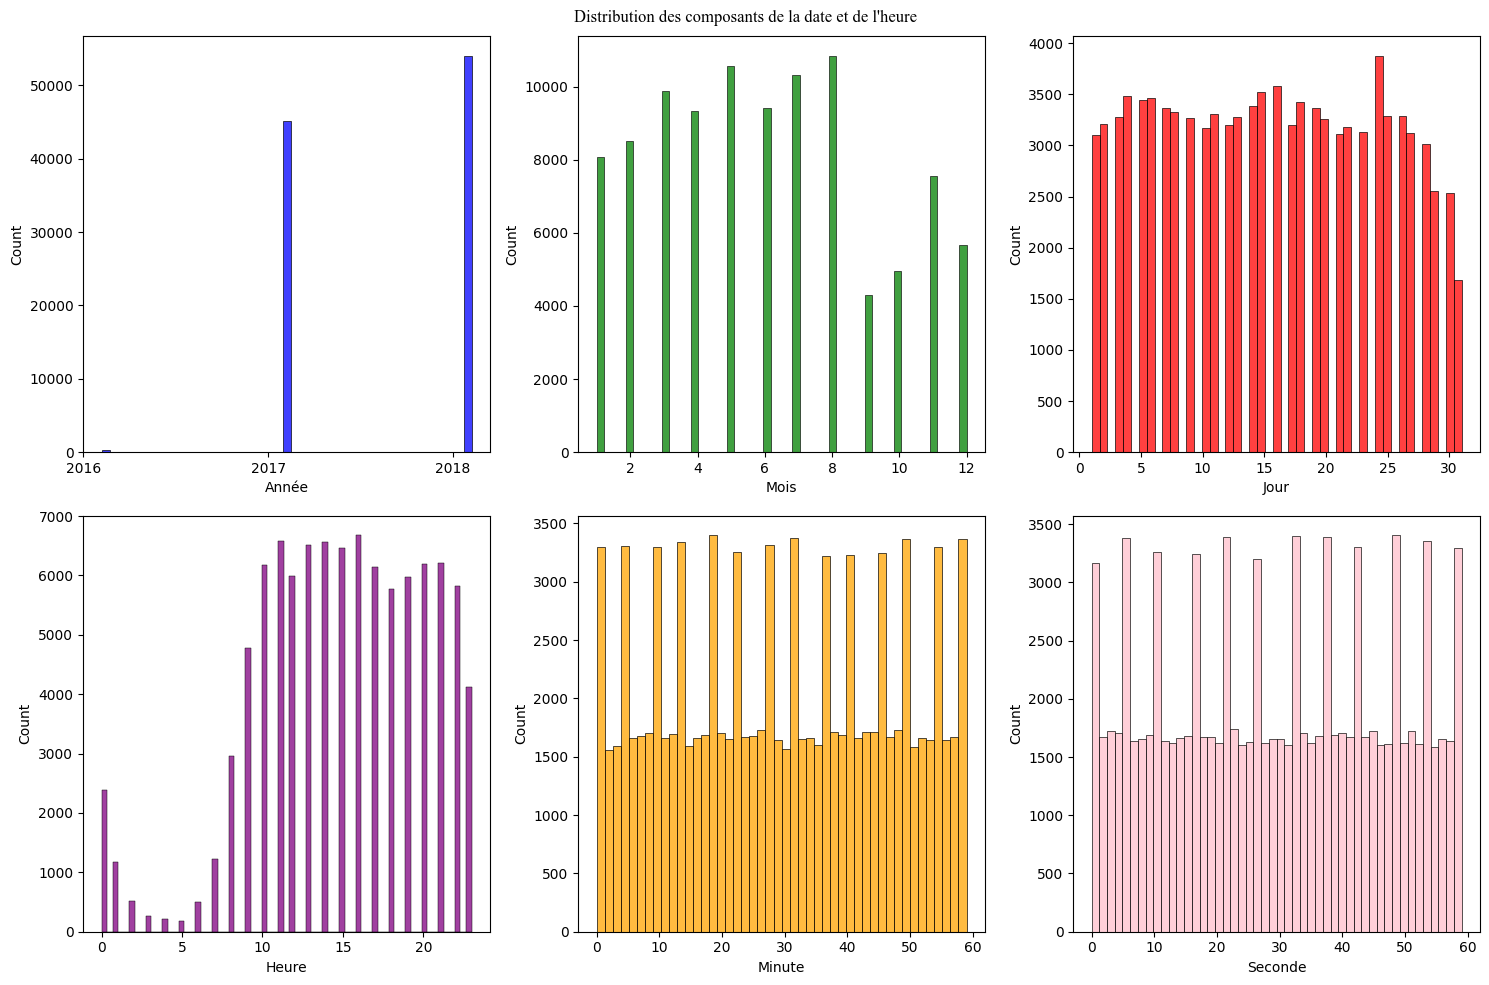

In [236]:
plot_distribution_datetime(df_base_clean, 'order_purchase_timestamp')

Rien d'anormal. Il n'y a pas de valeurs abérrantes parmi les date et les heures. 

### <span style='background:black; color:white'>d/ Aperçu dataframe nettoyé</span>

In [237]:
affiche_aperçu_df(df_base_clean, "df_base_clean", "nettoyage", 3)

Voici l'aspect de 'df_base_clean' après nettoyage


,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49


99441 ligne(s) x 3 colonne(s)



## <span style='background:yellow; color:black'>7/ Fusion des fichiers</span>

### <span style='background:black; color:white'>a/ Données de base - client</span>

Nous commençons la fusion sur le fichier "df_base_clean" car sa position dans la relation entre les fichiers est centrale, c'est à dire qu'il est lié à tous les autres fichiers.

Tout d'abord, regardons sa feature 'customer_id' :

In [238]:
afficheur_dimension_et_unique(df_base_clean, "df_base_clean", "clients associés à autant de commande", "customer_id")

'df_base_clean' contient 99441 lignes et 3 colonnes
'df_base_clean' contient 99441 clients associés à autant de commande différent(e)s


Nous allons lui fusionner le 'df_clients_clean' dont voici la feature 'customer_id' des commandes :

In [239]:
afficheur_dimension_et_unique(df_clients_clean, "df_clients_clean", "clients associés à autant de commande", "customer_id")

'df_clients_clean' contient 99441 lignes et 2 colonnes
'df_clients_clean' contient 99441 clients associés à autant de commande différent(e)s


Nous réalisons une jointure interne pour conserver les commandes présentes dans les 2 fichiers.

In [240]:
# Fusionner les DataFrame
df_merged_client = pd.merge(df_base_clean, df_clients_clean, on='customer_id', how='inner')

Nous vérifions que la fusion s'est bien déroulée :

In [241]:
afficheur_dimension_et_unique(df_merged_client, "df_merged_client", "commandes", "order_id")

'df_merged_client' contient 99441 lignes et 4 colonnes
'df_merged_client' contient 99441 commandes différent(e)s


In [242]:
affiche_aperçu_df(df_merged_client, "df_merged_client", "fusion 'donnée de base - clients'", 3)

Voici l'aspect de 'df_merged_client' après fusion 'donnée de base - clients'


,order_id,customer_id,order_purchase_timestamp,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8


99441 ligne(s) x 4 colonne(s)



### <span style='background:black; color:white'>b/ Ajout des paiements</span>

Regardons les commandes ('order_id') dans le dataframe fusionné :

In [243]:
afficheur_dimension_et_unique(df_merged_client, "df_merged_client", "commandes", "order_id")

'df_merged_client' contient 99441 lignes et 4 colonnes
'df_merged_client' contient 99441 commandes différent(e)s


Regardons les commandes ('order_id') dans le fichier des paiements :

In [244]:
afficheur_dimension_et_unique(df_paiements_clean, "df_paiements_clean", "commandes", "order_id")

'df_paiements_clean' contient 103886 lignes et 2 colonnes
'df_paiements_clean' contient 99440 commandes différent(e)s


Nous ajoutons les paiements au dataframe fusionné :

In [245]:
# Fusionner les DataFrame
df_merged_paiement = pd.merge(df_merged_client, df_paiements_clean, on='order_id', how='inner')

Nous vérifions que la fusion s'est bien déroulée :

In [246]:
afficheur_dimension_et_unique(df_merged_paiement, "df_merged_paiement", "commandes", "order_id")

'df_merged_paiement' contient 103886 lignes et 5 colonnes
'df_merged_paiement' contient 99440 commandes différent(e)s


Nous avons perdu 1 commande de 'df_merged_client' car nous n'avons pas son montant de paiement associé. 

In [247]:
affiche_aperçu_df(df_merged_paiement, "df_merged_paiement", "l'ajout des paiements'", 3)

Voici l'aspect de 'df_merged_paiement' après l'ajout des paiements'


,order_id,customer_id,order_purchase_timestamp,customer_unique_id,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59


103886 ligne(s) x 5 colonne(s)



### <span style='background:black; color:white'>c/ Ajout des avis</span>

Regardons les commandes ('order_id') dans le dataframe fusionné :

In [248]:
afficheur_dimension_et_unique(df_merged_paiement, "df_merged_paiement", "commandes", "order_id")

'df_merged_paiement' contient 103886 lignes et 5 colonnes
'df_merged_paiement' contient 99440 commandes différent(e)s


Regardons les commandes ('order_id') dans le fichier des avis :

In [249]:
afficheur_dimension_et_unique(df_avis_clean, "df_avis_clean", "commandes", "order_id")

'df_avis_clean' contient 99224 lignes et 2 colonnes
'df_avis_clean' contient 98673 commandes différent(e)s


Nous ajoutons les avis au dataframe fusionné :

In [250]:
# Fusionner les DataFrame
df_merged_avis = pd.merge(df_merged_paiement, df_avis_clean, on='order_id', how='inner')

Nous vérifions que la fusion s'est bien déroulée :

In [251]:
afficheur_dimension_et_unique(df_merged_avis, "df_merged_avis", "commandes", "order_id")

'df_merged_avis' contient 103677 lignes et 6 colonnes
'df_merged_avis' contient 98672 commandes différent(e)s


Nous avons perdu 768 commandes de 'df_merged_paiement' car nous n'avons pas leurs avis associés.

A noter qu'il y a 1 commande présente dans 'df_avis_clean' que nous perdons car elle n'est pas présente dans 'df_merged_paiement'.

In [252]:
affiche_aperçu_df(df_merged_avis, "df_merged_avis", "l'ajout des avis'", 3)

Voici l'aspect de 'df_merged_avis' après l'ajout des avis'


,order_id,customer_id,order_purchase_timestamp,customer_unique_id,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12,4
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00,4
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59,4


103677 ligne(s) x 6 colonne(s)



### <span style='background:black; color:white'>d/ Ajout des articles</span>

Regardons les commandes ('order_id') dans le dataframe fusionné :

In [253]:
afficheur_dimension_et_unique(df_merged_avis, "df_merged_avis", "commandes", "order_id")

'df_merged_avis' contient 103677 lignes et 6 colonnes
'df_merged_avis' contient 98672 commandes différent(e)s


Regardons les commandes ('order_id') dans le fichier des articles :

In [254]:
afficheur_dimension_et_unique(df_articles_clean, "df_articles_clean", "commandes", "order_id")

'df_articles_clean' contient 112650 lignes et 4 colonnes
'df_articles_clean' contient 98666 commandes différent(e)s


Nous ajoutons les avis au dataframe fusionné :

In [255]:
# Fusionner les DataFrame
df_merged = pd.merge(df_merged_avis, df_articles_clean, on='order_id', how='inner')

Nous vérifions que la fusion s'est bien déroulée :

In [256]:
afficheur_dimension_et_unique(df_merged, "df_merged", "commandes", "order_id")

'df_merged' contient 117329 lignes et 9 colonnes
'df_merged' contient 97916 commandes différent(e)s


Nous avons perdu 756 commandes. 

Il y a 6 commandes de 'df_merged_avis' qui sont des commandes qui ne sont pas présentes dans 'df_articles_clean'. Et il y a 750 commandes qui ne sont pas présentes dans 'df_articles_clean' et 'df_merged_avis' simultanément.

## <span style='background:yellow; color:black'>8/ Bilan du dataframe fusionné</span>

### <span style='background:green'>a/ Aperçu tableau</span>

In [257]:
affiche_aperçu_df(df_merged, "df_merged", "la fusion des informations utiles", 3)

Voici l'aspect de 'df_merged' après la fusion des informations utiles


,order_id,customer_id,order_purchase_timestamp,customer_unique_id,payment_value,review_score,order_item_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12,4,1,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00,4,1,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59,4,1,29.99,8.72


117329 ligne(s) x 9 colonne(s)




Informations sur les features du dataframe fusionné :
- **order_id** : identifiant des commandes
- **customer_id** : identifiant des clients associés aux commandes
- **order_purchase_timestamp** : date d'achat de la commande
- **customer_unique_id** : identifiant unique des clients
- **payment_value** : montant du paiement
- **review_score** : score/note de l'avis
- **order_item_id** : nombre d'articles commandés
- **price** : prix
- **freight_value** : valeur du fret

### <span style='background:green'>b/ Valeurs manquantes</span>

In [258]:
df_merged.isna().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
customer_unique_id          0
payment_value               0
review_score                0
order_item_id               0
price                       0
freight_value               0
dtype: int64

Il n'y a pas de valeurs manquantes.

### <span style='background:green'>c/ Doublons</span>

In [259]:
df_merged.duplicated().sum()

1103

Il y a 1_103 lignes en doublosn. Nous conservons la première ligne de chaque doublon et nous supprimons les autres.

In [260]:
df_merged_clean = df_merged.drop_duplicates(keep='first')

Nous vérifions que les doublons ont bien été supprimés :

In [261]:
df_merged_clean.duplicated().sum()

0

### <span style='background:green'>d/ Structure</span>

In [262]:
df_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116226 entries, 0 to 117328
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  116226 non-null  object        
 1   customer_id               116226 non-null  object        
 2   order_purchase_timestamp  116226 non-null  datetime64[ns]
 3   customer_unique_id        116226 non-null  object        
 4   payment_value             116226 non-null  float64       
 5   review_score              116226 non-null  int64         
 6   order_item_id             116226 non-null  int64         
 7   price                     116226 non-null  float64       
 8   freight_value             116226 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 8.9+ MB


Ce dataframe fusionné contient 116_226 lignes et 9 colonnes.

### <span style='background:green'>e/ Inspection des données</span>

Résumé des features **quantitatives** :

In [263]:
df_merged_clean.describe().round(2)

,order_purchase_timestamp,payment_value,review_score,order_item_id,price,freight_value
count,116226,116226.00,116226.00,116226.00,116226.00,116226.00
mean,2017-12-30 19:58:10.008483328,172.97,4.03,1.19,120.60,20.02
min,2016-09-04 21:15:19,0.00,1.00,1.00,0.85,0.00
25%,2017-09-12 09:23:36.750000128,61.42,4.00,1.00,39.90,13.08
50%,2018-01-18 16:48:57.500000,108.76,5.00,1.00,74.90,16.28
75%,2018-05-04 00:24:03.249999872,189.56,5.00,1.00,134.90,21.18
max,2018-09-03 09:06:57,13664.08,5.00,21.00,6735.00,409.68
std,NaN,266.18,1.39,0.68,183.14,15.81


Résumé des features **qualitatives** : 

In [264]:
df_merged_clean.describe(exclude=[np.number, 'datetime64[ns]'])

,order_id,customer_id,customer_unique_id
count,116226,116226,116226
unique,97916,97916,94720
top,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,f9ae226291893fda10af7965268fb7f6
freq,34,34,35


<div class="alert alert-block alert-success"><b>Bilan: </b>

Ce dataframe fusionné **'df_merged_clean'** contient 116_226 lignes concernant **97_916 commandes** :
- réalisées entre le 04/09/2016 et le 03/09/2018
<br>

- comportant entre 1 et 21 articles différents dont les prix unitaires varient entre 0,85 R$ et 6_735 R$

- pour un montant :
  - d'achat compris entre 0 R$ et 13_664 R$
  - de fret compris entre 0 R$ et 409 R$
<br><br>
- par **94_720 clients** différents qui ont écrit des avis entre 1/5 et 5/5.
</div> 

## <span style='background:yellow; color:black'>9/ Extraction des données des clients ayant fait plusieurs commandes</span>

Comme nous le demande Olist, nous allons nous concentrer sur les clients ayant réalisé plusieurs commandes.

In [283]:
# Nombre de commande à dépasser pour qu'un client devient récurrent
nombre_recurrence_commande = 2

# Identifications des clients récurrents
clients_tous = df_merged_clean['customer_unique_id'].value_counts()
clients_recurrents = clients_tous[clients_tous > nombre_recurrence_commande]

# Nombre de clients récurrents (absolu et pourcentage)
clients_recurrents_nb = clients_recurrents.shape[0]
clients_recurrents_pourcent = round(clients_recurrents_nb / clients_tous.shape[0] * 100, 2)

# Affichage des résultats
print("Il y a {0} client(s) récurrent(s) donc qui ont réalisés plus de {1} commandes.\nCela représente {2} % du panel des clients.".format(str(clients_recurrents_nb), nombre_recurrence_commande, clients_recurrents_pourcent))


Il y a 3560 client(s) récurrent(s) donc qui ont réalisés plus de 2 commandes.
Cela représente 3.76 % du panel des clients.


Nous filtrons le dataframe fusionné pour ne conserver que les clients ayant réalisé plusieurs commandes.

In [284]:
# Filtrage du df_merged pour ne garder que les clients récurrents
df_merged_filtred = df_merged_clean[df_merged_clean['customer_unique_id'].isin(clients_recurrents.index)]

Résumé des features **quantitatives** :

In [285]:
df_merged_filtred.describe().round(2)

,order_purchase_timestamp,payment_value,review_score,order_item_id,price,freight_value
count,14439,14439.00,14439.00,14439.00,14439.00,14439.00
mean,2017-12-18 23:14:44.663273216,293.06,3.60,2.10,87.40,19.01
min,2016-10-03 09:44:50,0.00,1.00,1.00,1.20,0.00
25%,2017-08-30 17:21:25,80.13,2.00,1.00,30.90,11.97
50%,2018-01-04 22:52:45,174.39,4.00,2.00,56.99,15.95
75%,2018-04-22 18:16:11,335.00,5.00,3.00,99.99,20.84
max,2018-08-29 08:46:11,13664.08,5.00,21.00,2499.75,299.16
std,NaN,503.15,1.61,1.55,113.85,15.47


Résumé des features **qualitatives** : 

In [286]:
df_merged_filtred.describe(exclude=[np.number, 'datetime64[ns]'])

,order_id,customer_id,customer_unique_id
count,14439,14439,14439
unique,4909,4909,3560
top,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,f9ae226291893fda10af7965268fb7f6
freq,34,34,35


In [287]:
# Affichage df 
affiche_aperçu_df(df_merged_filtred, "df_merged_filtred", "le filtrage des clients récurrents", 3)

Voici l'aspect de 'df_merged_filtred' après le filtrage des clients récurrents


,order_id,customer_id,order_purchase_timestamp,customer_unique_id,payment_value,review_score,order_item_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12,4,1,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00,4,1,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59,4,1,29.99,8.72


14439 ligne(s) x 9 colonne(s)



<div class="alert alert-block alert-success"><b>Bilan: </b>

Ce dataframe fusionné **'df_merged_filtred'** contient 14_439 lignes concernant **4_909 commandes** :
- réalisées entre le 03/10/2016 et le 29/08/2018
<br>

- comportant entre 1 et 21 articles différents dont les prix unitaires varient entre 1,20 R$ et 2_499 R$

- pour un montant :
  - d'achat compris entre 0 R$ et 13_664 R$
  - de fret compris entre 0 R$ et 299 R$
<br><br>
- par **3_560 clients** différents qui ont écrit des avis entre 1/5 et 5/5.
</div>

## <span style='background:yellow; color:black'>10/ Segmentation RFM+S</span>

Je calcule les 3 indicateurs RFM :
- **Récence** : nombre de jours depuis la dernière commande
- **Fréquence** : nombre de commandes
- **Montant** : montant total des commandes

J'ajoute à ce dataset l'indicateur relatif aux avis :
- **Satisfaction** : note moyenne des avis

In [303]:
# Calculer récence, fréquence et montant (price + freight) pour chaque client
rfms = df_merged_filtred.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (df_merged_filtred['order_purchase_timestamp'].max() - x.max()).days,
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum',
    'review_score': 'mean'
    })

# Ajouter 'price' et 'freight_value' ensemble pour obtenir le 'montant'
rfms['montant'] = rfms['price'] + rfms['freight_value']

# Supprimer les features 'price' et 'freight_value' car plus nécessaires
rfms.drop(['price', 'freight_value'], axis=1, inplace=True)

# Renommer les autres features
rfms.rename(columns={
    'order_purchase_timestamp': 'recence',
    'order_id': 'frequence',
    'review_score': 'satisfaction'}, 
    inplace=True)

# Réordonner les colonnes RFM+S
rfms = rfms[['recence', 'frequence', 'montant', 'satisfaction']]

# Affichage df
display(rfms.head(3))
display(rfms.shape)

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36,5.00000
0058f300f57d7b93c477a131a59b36c3,159,3,271.60,3.66667
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20,5.00000


(3560, 4)

# <span style='background:blue'>Etape 3 : Analyse exploratoire</span>

## <span style='background:yellow; color:black'>1/ Analyse univariée</span>

Nous affichons la distribution de la récence :

<Axes: xlabel='recence', ylabel='Count'>

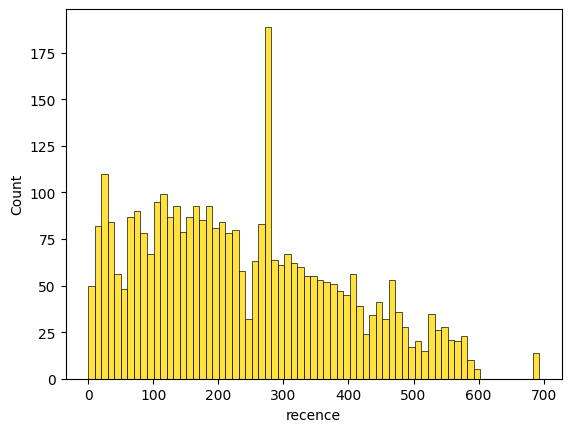

In [304]:
sns.histplot(rfms['recence'], kde=False, color=colors_list[0], binwidth=10)

Nous affichons la distribution de la fréquence :

<Axes: xlabel='frequence', ylabel='Count'>

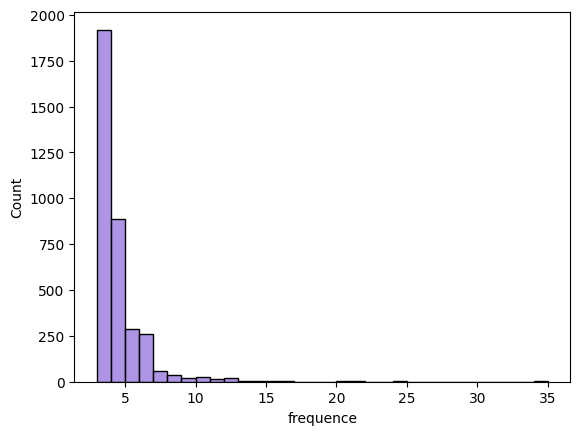

In [305]:
sns.histplot(rfms['frequence'], kde=False, color=colors_list[1], binwidth=1)

Nous affichons la distribution du montant :

<Axes: xlabel='montant', ylabel='Count'>

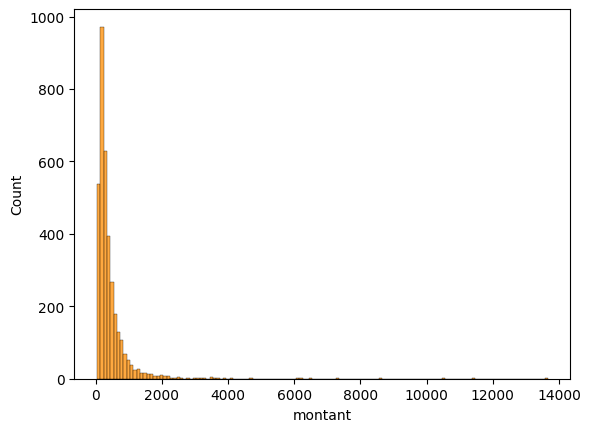

In [308]:
sns.histplot(rfms['montant'], kde=False, color=colors_list[2], binwidth=100)

Nous affichons la distribution de la satisfaction :

<Axes: xlabel='satisfaction', ylabel='Count'>

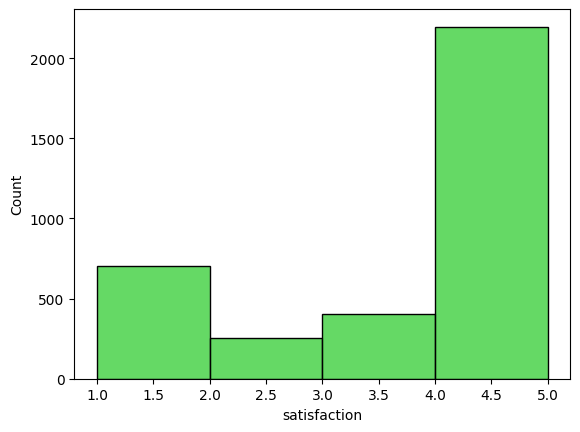

In [309]:
sns.histplot(rfms['satisfaction'], kde=False, color=colors_list[3], binwidth=1)

## <span style='background:yellow; color:black'>2/ Analyse bivariée</span>

Nous explorons les relations entre les variables grâce à une matrice de corrélation :

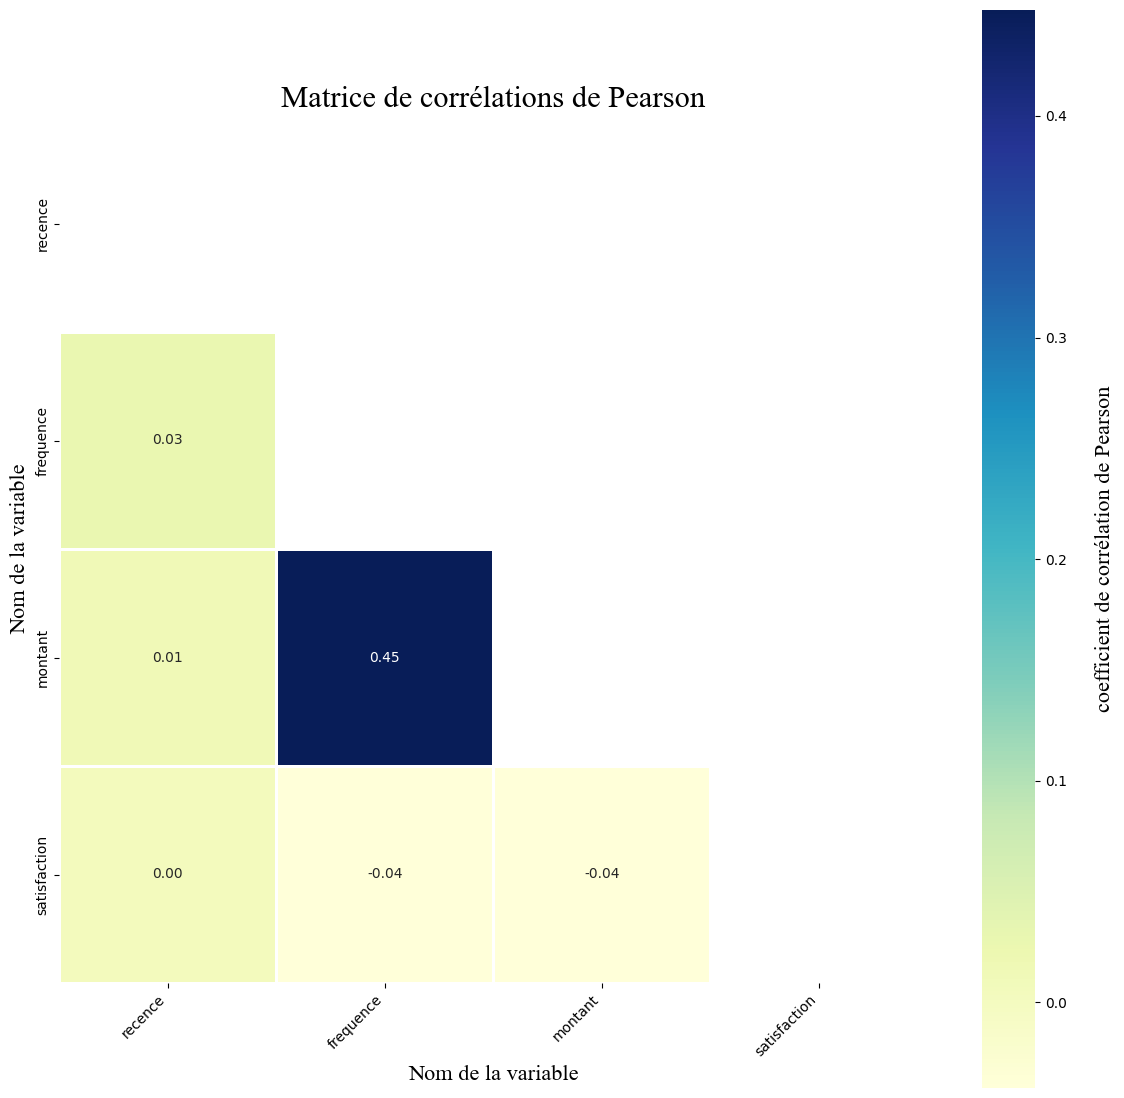

In [310]:
# matrice de corrélation
corr_matrix = rfms.corr()

# Créer un masque pour masquer les valeurs au-dessus de la diagonale
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# heatmap
fig, ax = plt.subplots(figsize=(14,14))
heatmap = sns.heatmap(corr_matrix, square=True, linewidths=1, annot=True, fmt=".2f", cmap='YlGnBu', mask=mask, ax=ax)

# Ajout du titre du graphique, des axes et de la colorbar
plt.title("Matrice de corrélations de Pearson", fontdict=font_title)
plt.xlabel("Nom de la variable", fontdict=font_axe)
plt.ylabel("Nom de la variable", fontdict=font_axe)
plt.xticks(rotation=45, ha='right')
cbar = heatmap.collections[0].colorbar
cbar.set_label('coefficient de corrélation de Pearson', labelpad=20, fontdict=font_axe)  
plt.show()

Il n'y a pas de corrélation forte antre les features. Nous remarquons néanmoins une corrélation modérée entre la fréquence et le montant (r=0,45).

# <span style='background:blue'>Etape 4 : Exportation du dataset nettoyé</span>
___

In [311]:
# Aperçu dataframe nettoyé
affiche_aperçu_df(rfms, "rfms", "la segmentation RFM et satisfaction", 3)

Voici l'aspect de 'rfms' après la segmentation RFM et satisfaction


,recence,frequence,montant,satisfaction
customer_unique_id,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36,5.00000
0058f300f57d7b93c477a131a59b36c3,159,3,271.60,3.66667
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20,5.00000


3560 ligne(s) x 4 colonne(s)



Nous allons sauvegarder le dataset pour l'utiliser dans nos modèles de machine learning.

In [313]:
# Chemin du dossier et nom du fichier de l'export nettoyé
output_directory = "data/cleaned"
nomFichier_export = "olist_clients_segmentation.csv"

# Vérification de l'existence du dossier
os.makedirs(output_directory, exist_ok=True)

# Chemin complet du fichier export
output_file = os.path.join(output_directory, nomFichier_export)

# export df nettoyé en CSV (tabulation en séparateur)
rfms.to_csv(output_file, sep='\t', encoding='utf-8', index=True)

# <span style='background:blue'>Conclusion</span>

# <span style='background:red; color:white'>A METTRE A JOUR</span>



In [296]:
# Calculer et afficher la durée totale
total_time = time.time() - start_time

# Convertir en minutes et secondes
minutes, seconds = divmod(total_time, 60)

# Afficher la durée totale
print("Durée totale pour faire tourner le notebook : {0} minute(s) {1} seconde(s)".format(int(minutes), int(seconds)))

Durée totale pour faire tourner le notebook : 31 minute(s) 28 seconde(s)
